In [251]:
# Load basic libraries that you will almost certainly use. You may need others.
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit
from astropy.io import fits
import pandas as pd
from astropy.utils.data import download_file
import statistics
from scipy.stats import powerlaw
from scipy.stats import iqr
import operator 
np.set_printoptions(threshold=np.nan)

In [252]:
# Set up for plotting. All these settings just help to produce "nicer" looking plots, but you don't need to use them per se.
bfsize=22
plt.rcParams['figure.figsize'] = (8,5.5)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelsize'] = bfsize
plt.rcParams['axes.labelpad'] = 1.0
plt.rcParams['axes.labelweight'] = 540 # 400 is normal, 700 is bold
plt.rcParams['xtick.major.width'] = 1.4
plt.rcParams['ytick.major.width'] = 1.4
plt.rcParams['xtick.major.size'] = 0.3*bfsize
plt.rcParams['ytick.major.size'] = 0.3*bfsize
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 0.13*bfsize
plt.rcParams['ytick.minor.size'] = 0.13*bfsize
plt.rcParams['xtick.labelsize'] = 0.8*bfsize
plt.rcParams['ytick.labelsize'] = 0.8*bfsize
plt.rcParams['xtick.major.pad'] = 0.155*bfsize
plt.rcParams['ytick.major.pad'] = 0.155*bfsize
plt.rcParams['xtick.minor.pad'] = 0.155*bfsize
plt.rcParams['ytick.minor.pad'] = 0.155*bfsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.fancybox'] = 'True'
plt.rcParams['legend.fontsize'] = 0.9*bfsize
plt.rcParams['legend.labelspacing'] = 0.25
plt.rcParams['legend.handletextpad'] = 0.35
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.borderaxespad'] = 0.6
plt.rcParams['legend.columnspacing'] = 0.2
plt.rcParams['legend.frameon'] = 'False'
plt.rcParams['legend.edgecolor'] = 'black'

In [253]:
# Example function to read in an old SDSS spectrum FITS file
def rSDSSFITS(FITSfile):
    with fits.open(FITSfile) as hdulist:
        h0=hdulist[0].header
        h1=hdulist[1].header
        d1=hdulist[1].data
        n=d1.shape[-1]
        lw=d1['loglam']
        wl=np.power(10.0,lw)
        ivar=d1['ivar']
        #[-np.inf if x<=0 else x for x in ivar]
        #sig=np.reciprocal(np.sqrt(ivar)) 
        #'sig':sig,
        er=ivar
    return {'wl':wl,'lw':lw,'fl':d1['flux'],'er':d1[2],'ivar':ivar,'h0':h0,'h1':h1}

In [254]:
FITSfile='spec-4619-55599-0246.fits'
s=rSDSSFITS(FITSfile)

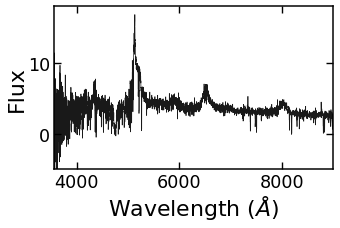

In [422]:
fig=plt.figure(figsize=(5.0,3.0))
#simplifies the plotting
x=s['wl']
y=np.array(s['fl'])
#attempt to make the calculations of spec index easier later
a = np.array(x)
b = np.array(y)
xy=np.column_stack((a,b))
#redshift of current QSO, change with each or later make reference
z=3.220472
z1=z+1
#converts the observed wavelengths to the rest frame 
xr=x/(1+z)
# spectral regions in rest frame wavelengths
#[1276,1292],[1314,1328],[1345,1362],[1435,1465],[1684,1700]


# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1=plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)
xmin1,xmax1=s['wl'][0],s['wl'][-1]
xrng=xmax1-xmin1
#xmin2,xmax2
ymax1=18
ymin1=-5
yrng=ymax-ymin
#ax1.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=2.0)
ax1.step(x,y,where='mid',lw=.7,color=myc['black'],alpha=0.9,rasterized=True)
ax1.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize)
ax1.set_xlabel(r'Wavelength ($\AA$)',ha='center',va='bottom',fontsize=bfsize,labelpad=30)
#search label padding
#ax1.annotate(r'Huggins O$_3$',xy=(0.75,0.45),xycoords='axes fraction',color='black',
#             ha='center',va='center',fontsize=0.9*bfsize)
ax1.set_xlim(xmin1,9000)
ax1.set_ylim(ymin1,ymax)
#ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
#Fix so that axis 2 is displayed
ax2.step(xr,y,where='mid',lw=.7,color=myc['black'],alpha=0.9,rasterized=True)
ax2.set_xlabel(r'Rest Wavelength ($\AA$)',ha='center',va='bottom',fontsize=bfsize,labelpad=30)
ax2.spines['top'].set_position(('outward', 36))
plt.show()
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0,hspace=0)
fig.tight_layout()
# Export to PDF
#plt.savefig('DR1_cosmic.pdf',bbox_inches='tight',pad_inches=0.05)


In [470]:
#spectral bands in rest wavelengths converted to obs [upper,lower]
obspreg=np.array(([5385.32227,5452.849824],[5545.700208,5604.786816],[5676.53484,5748.282864],[6056.37732,6182.99148],[7107.274848,7174.8024]))
#The median values of the 5 spectral regions,the same for all quasar spectra (observed wavelength)
medspreg=[5419.086047, 5575.243512, 5712.4088520000005, 6119.6844, 7141.038624]

#spectral bands in observed wavelengths
fval=[]
for i in range(0,5):
    g1=y[(x>=ospre[i][0]) & (x<=ospre[i][1])]
    fval.append(g1)
#interquartile values for flux
iqrval=[]
for i in range(0,5):
    g2=iqr(fval[i],rng=(25,75))
    iqrval.append(g2)
#median values for flux    
fmed=[]
for i in range(0,5):
    g3=np.median(fval[i])
    fmed.append(g3)

[4.4181213, 4.199759, 4.0613756, 3.6291542, 3.1848962]

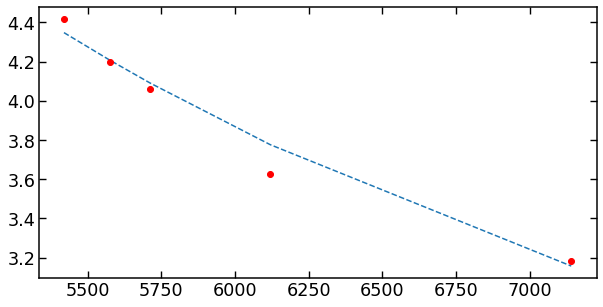

In [480]:
def func_powerlaw(lam, m, c):
    return c*lam**m

X=medspreg
Y=fmed

popt, pcov = curve_fit(func_powerlaw,X,Y,sigma=iqrval)

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--')
plt.plot(X, Y, 'ro')
plt.show()

In [475]:
popt

array([-1.16042210e+00,  9.35931354e+04])

In [476]:
pcov

array([[ 8.42462844e-03, -6.87217239e+03],
       [-6.87217239e+03,  5.60677535e+09]])